<h1><center>IST 597 Foundations of Deep Learning</center></h1>

---

<h2><center>Solving PDE with Neural Networks</center><h2>
<h3><center>Neisarg Dave</center><h3>

PDE:
$$
\frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = 0
$$

Boundary Conditions:

$$
u(x, 0) = e^{-x^2}
$$

$$
u(0, t) = 1 + \frac{t}{5}
$$



In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import random
import numpy as np

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(2,16)
        self.hidden2 = nn.Linear(16,16)
        self.hidden3 = nn.Linear(16,16)
        self.hidden4 = nn.Linear(16,16)
        self.output = nn.Linear(16,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1)
        layer1 = torch.sigmoid(self.hidden1(inputs))
        layer2 = torch.sigmoid(self.hidden2(layer1))
        layer3 = torch.sigmoid(self.hidden3(layer2))
        layer4 = torch.sigmoid(self.hidden4(layer3))
        output = self.output(layer4)
        return output

In [ ]:
### (2) Model
model = PINN()
model = model.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def f(x, t, model):
  u = model(x, t)
  du_dx = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
  du_dt = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
  pde = du_dt + du_dx
  return pde

In [ ]:
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def live_plots(weight, grad, x, y, xlim, ylim):
    clear_output(wait=True)
    fig = plt.figure(figsize=(32, 16))
    gs0 = gridspec.GridSpec(2, 2, figure=fig)
    #gs02 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[1])

    #plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(gs0[0])
    # ax3 = fig.add_subplot(gs00[-1, -1])
    ax1.set_xlim(0, xlim)
    ax1.set_ylim(0, ylim)
    x = [float(i) for i in x]
    y = [float(i) for i in y]

    if len(x) > 1:
        ax1.plot(x,y, label='loss', color='k', linewidth=2.0)
        # m, b = np.polyfit(x, y, 3)
        # plt.plot(x, [x * m for x in x] + b)

    ax1.set_title("Loss Curve")
    ax1.grid(True)
    ax1.set_xlabel('# Iterations')
    ax1.set_ylabel('Loss')

    #-------------------------------------------------------------

    ax2 = fig.add_subplot(gs0[1], projection='3d')
    x=np.arange(-5,5,0.02)
    t=np.arange(0,5,0.02)
    ms_x, ms_t = np.meshgrid(x, t)

    x = np.ravel(ms_x).reshape(-1,1)
    t = np.ravel(ms_t).reshape(-1,1)

    x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    u = model(x,t)
    u = u.data.cpu().numpy()
    ms_u = u.reshape(ms_x.shape)

    surf = ax2.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)

    ax2.zaxis.set_major_locator(LinearLocator(10))
    ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink = 0.5, aspect=5)

    #-------------------------------------------------------------

    ax3 = fig.add_subplot(gs0[2])
    ax3.hist(weight, 50, density=True, facecolor='g', alpha=0.75)
    ax3.set_title("Distribution of Weight Matrix")

    #-------------------------------------------------------------

    ax4 = fig.add_subplot(gs0[3])
    ax4.hist(grad, 50, density=True, facecolor='b', alpha=0.75)
    ax4.set_title("Distribution of Gradients of Weight Matrix")

    plt.show()

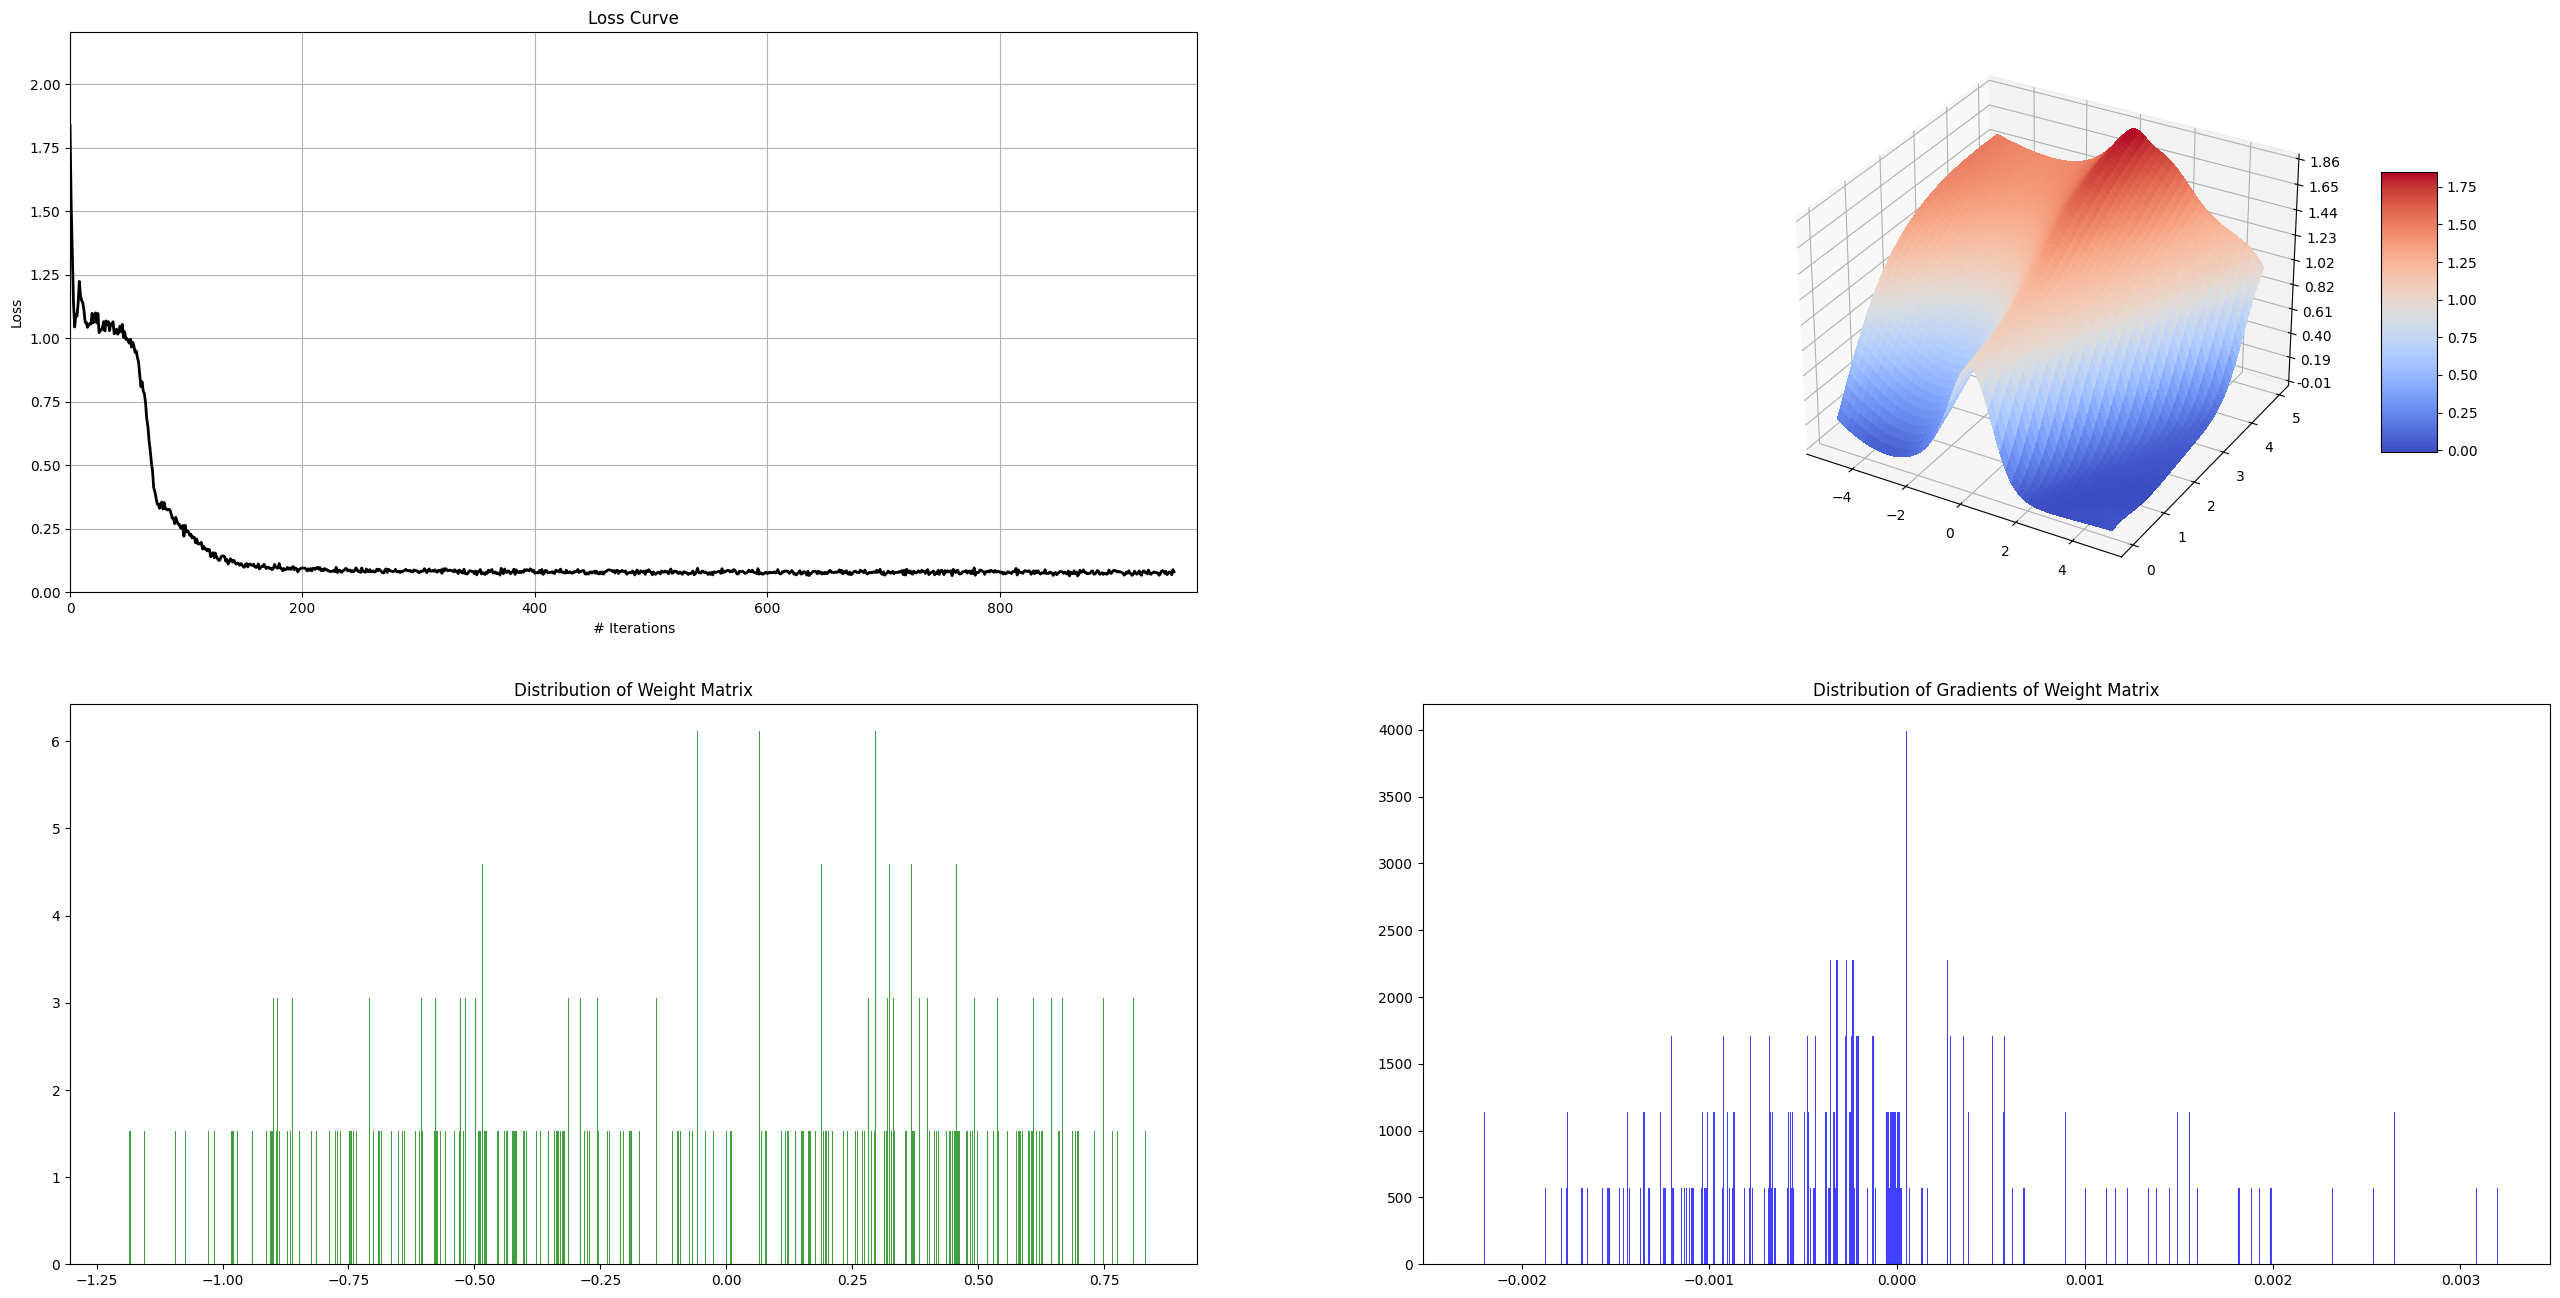

In [ ]:
iterations = 1000
loss_buffer = []
step_buffer = []
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    x_data = torch.from_numpy(np.random.uniform(low=-5, high=5, size=(500,1))).type(torch.float).to(device)
    t_data = torch.from_numpy(np.random.uniform(low=0, high=5, size=(500,1))).type(torch.float).to(device)
    all_zeros = torch.zeros(500,1, dtype = torch.float, device = device)

    u_x0 = torch.exp(-(x_data**2))
    u_0t = 1 + t_data/5


    # Loss based on boundary conditions
    bc_x = model(x_data, all_zeros)
    bc_t = model(all_zeros, t_data)
    mse_bcx = mse_cost_function(bc_x, u_x0)
    mse_bct = mse_cost_function(bc_t, u_0t)

    # Loss based on PDE
    x_data = Variable(x_data, requires_grad=True).to(device)
    t_data = Variable(t_data, requires_grad=True).to(device)
    f_out = f(x_data, t_data, model)
    mse_f = mse_cost_function(f_out, all_zeros)

    # Combining the loss functions
    loss = mse_bcx + mse_bct + mse_f


    loss.backward()
    optimizer.step()

    loss_buffer.append(loss.detach().cpu())
    step_buffer.append(epoch)
    if epoch % 50 == 0:
      live_plots(model.hidden3.weight.detach().cpu(), model.hidden3.weight.grad.detach().cpu(),
                 step_buffer, loss_buffer,
                epoch+20, max(loss_buffer)*1.2)
